<a href="https://colab.research.google.com/github/nadah09/6.832RacecarTrajOpt/blob/main/trajOpt.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 6.832 Final Project: Trajectory Optimization for Self-Driving Cars

In [1]:
try:
    import pydrake
    import underactuated
except ImportError:
    !curl -s https://raw.githubusercontent.com/RussTedrake/underactuated/master/scripts/setup/jupyter_setup.py > jupyter_setup.py
    from jupyter_setup import setup_underactuated
    setup_underactuated()

# Setup matplotlib backend (to notebook, if possible, or inline).  
from underactuated.jupyter import setup_matplotlib_backend
plt_is_interactive = setup_matplotlib_backend()

/content/jupyter_setup.py:13: UserWarning: jupyter_setup.py is deprecated.  Please use setup_underactuated_colab.py instead.
  warnings.warn("jupyter_setup.py is deprecated.  Please use"


Cloning into '/opt/underactuated'...

HEAD is now at 2a15bde minor reword on exercise 7.2 (#428)

ERROR: torchtext 0.9.1 has requirement torch==1.8.1, but you'll have torch 1.7.1 which is incompatible.
ERROR: bokeh 2.3.1 has requirement pillow>=7.1.0, but you'll have pillow 7.0.0 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.






In [2]:
# python libraries
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

# pydrake imports
from pydrake.all import (Variable, SymbolicVectorSystem, DiagramBuilder,
                         LogOutput, Simulator, ConstantVectorSource,
                         MathematicalProgram, Solve, SnoptSolver, PiecewisePolynomial)
import pydrake.symbolic as sym

In [3]:
n_x = 5
n_u = 2
def car_continuous_dynamics(x, u):
    # x = [x position, y position, heading, speed, steering angle] 
    # u = [acceleration, steering velocity]
    m = sym if x.dtype == object else np # Check type for autodiff
    heading = x[2]
    v = x[3]
    steer = x[4]
    x_d = np.array([
        v*m.cos(heading),
        v*m.sin(heading),
        v*m.tan(steer),
        u[0],
        u[1]        
    ])
    return x_d
def discrete_dynamics(x, u):
    dt = 0.1
    # TODO: Fill in the Euler integrator below and return the next state
    x_next = x + dt * car_continuous_dynamics(x, u)
    return x_next
def rollout(x0, u_trj):
    x_trj = np.zeros((u_trj.shape[0]+1, x0.shape[0]))
    x_trj[0] = x0
    # TODO: Define the rollout here and return the state trajectory x_trj: [N, number of states]
    for i in range(1, u_trj.shape[0] + 1):
      x_trj[i] = discrete_dynamics(x_trj[i - 1], u_trj[i - 1])
    return x_trj

# Debug your implementation with this example code
N = 10
x0 = np.array([1, 0, 0, 1, 0])
u_trj = np.zeros((N-1, n_u))
x_trj = rollout(x0, u_trj)

In [4]:
r = 2.0
v_target = 2.0
eps = 1e-6 # The derivative of sqrt(x) at x=0 is undefined. Avoid by subtle smoothing
def cost_stage(x, u):
    m = sym if x.dtype == object else np # Check type for autodiff
    c_circle = (m.sqrt(x[0]**2 + x[1]**2 + eps) - r)**2
    c_speed = (x[3]-v_target)**2
    c_control= (u[0]**2 + u[1]**2)*0.1
    return c_circle + c_speed + c_control

def cost_final(x):
    m = sym if x.dtype == object else np # Check type for autodiff
    c_circle = (m.sqrt(x[0]**2 + x[1]**2 + eps) - r)**2
    c_speed = (x[3]-v_target)**2
    return c_circle + c_speed

In [5]:
def cost_trj(x_trj, u_trj):
    total = 0.0
    total = sum([cost_stage(x_trj[i, :], u_trj[i, :]) for i in range(x_trj.shape[0]-1)])
    total += cost_final(x_trj[-1, :])
    return total

In [7]:
class derivatives():
    def __init__(self, discrete_dynamics, cost_stage, cost_final, n_x, n_u):
        self.x_sym = np.array([sym.Variable("x_{}".format(i)) for i in range(n_x)])
        self.u_sym = np.array([sym.Variable("u_{}".format(i)) for i in range(n_u)])
        x = self.x_sym
        u = self.u_sym
        
        l = cost_stage(x, u)
        self.l_x = sym.Jacobian([l], x).ravel()
        self.l_u = sym.Jacobian([l], u).ravel()
        self.l_xx = sym.Jacobian(self.l_x, x)
        self.l_ux = sym.Jacobian(self.l_u, x)
        self.l_uu = sym.Jacobian(self.l_u, u)
        
        l_final = cost_final(x)
        self.l_final_x = sym.Jacobian([l_final], x).ravel()
        self.l_final_xx = sym.Jacobian(self.l_final_x, x)
        
        f = discrete_dynamics(x, u)
        self.f_x = sym.Jacobian(f, x)
        self.f_u = sym.Jacobian(f, u)
    
    def stage(self, x, u):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        env.update({self.u_sym[i]: u[i] for i in range(u.shape[0])})
        
        l_x = sym.Evaluate(self.l_x, env).ravel()
        l_u = sym.Evaluate(self.l_u, env).ravel()
        l_xx = sym.Evaluate(self.l_xx, env)
        l_ux = sym.Evaluate(self.l_ux, env)
        l_uu = sym.Evaluate(self.l_uu, env)
        
        f_x = sym.Evaluate(self.f_x, env)
        f_u = sym.Evaluate(self.f_u, env)

        return l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u
    
    def final(self, x):
        env = {self.x_sym[i]: x[i] for i in range(x.shape[0])}
        
        l_final_x = sym.Evaluate(self.l_final_x, env).ravel()
        l_final_xx = sym.Evaluate(self.l_final_xx, env)
        
        return l_final_x, l_final_xx
        
derivs = derivatives(discrete_dynamics, cost_stage, cost_final, n_x, n_u)
# Test the output:
# x = np.array([0, 0, 0, 0, 0])
# u = np.array([0, 0])
# print(derivs.stage(x, u))
# print(derivs.final(x))

In [8]:
def Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx):
    # TODO: Define the Q-terms here
    Q_x = l_x + f_x.T.dot(V_x)
    Q_u = l_u + f_u.T.dot(V_x)
    Q_xx = l_xx + f_x.T.dot(V_xx).dot(f_x)  
    Q_ux = l_ux + f_u.T.dot(V_xx).dot(f_x)
    Q_uu = l_uu + f_u.T.dot(V_xx).dot(f_u)
    return Q_x, Q_u, Q_xx, Q_ux, Q_uu

In [9]:
def gains(Q_uu, Q_u, Q_ux):
    Q_uu_inv = np.linalg.inv(Q_uu)
    # TOD: Implement the feedforward gain k and feedback gain K.
    k = -Q_uu_inv.dot(Q_u)
    K = -Q_uu_inv.dot(Q_ux)
    return k, K

In [10]:
def V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k):
    # TODO: Implement V_x and V_xx, hint: use the A.dot(B) function for matrix multiplcation.
    V_x = Q_x - K.T.dot(Q_uu).dot(k)
    V_xx = Q_xx - K.T.dot(Q_uu).dot(K)
    return V_x, V_xx

In [11]:
def expected_cost_reduction(Q_u, Q_uu, k):
    return -Q_u.T.dot(k) - 0.5 * k.T.dot(Q_uu.dot(k))

In [12]:
def forward_pass(x_trj, u_trj, k_trj, K_trj):
    x_trj_new = np.zeros(x_trj.shape)
    x_trj_new[0,:] = x_trj[0,:]
    u_trj_new = np.zeros(u_trj.shape)
    # TODO: Implement the forward pass here
    for n in range(u_trj.shape[0]):
      u_trj_new[n,:] = u_trj[n] + k_trj[n] + K_trj[n, :, :].dot(x_trj_new[n] - x_trj[n])# Apply feedback law
      x_trj_new[n+1,:] = discrete_dynamics(x_trj_new[n], u_trj_new[n]) # Apply dynamics
    return x_trj_new, u_trj_new

In [13]:
def backward_pass(x_trj, u_trj, regu):
    k_trj = np.zeros([u_trj.shape[0], u_trj.shape[1]])
    K_trj = np.zeros([u_trj.shape[0], u_trj.shape[1], x_trj.shape[1]])
    expected_cost_redu = 0
    # TODO: Set terminal boundary condition here (V_x, V_xx)
    V_x, V_xx = derivs.final(x_trj[-1, :])
    for n in range(u_trj.shape[0]-1, -1, -1):
        # TODO: First compute derivatives, then the Q-terms 
        l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u = derivs.stage(x_trj[n, :], u_trj[n, :])
        Q_x, Q_u, Q_xx, Q_ux, Q_uu = Q_terms(l_x, l_u, l_xx, l_ux, l_uu, f_x, f_u, V_x, V_xx)

        # We add regularization to ensure that Q_uu is invertible and nicely conditioned
        Q_uu_regu = Q_uu + np.eye(Q_uu.shape[0])*regu
        k, K = gains(Q_uu_regu, Q_u, Q_ux)
        k_trj[n,:] = k
        K_trj[n,:,:] = K
        V_x, V_xx = V_terms(Q_x, Q_u, Q_xx, Q_ux, Q_uu, K, k)
        expected_cost_redu += expected_cost_reduction(Q_u, Q_uu, k)
    return k_trj, K_trj, expected_cost_redu

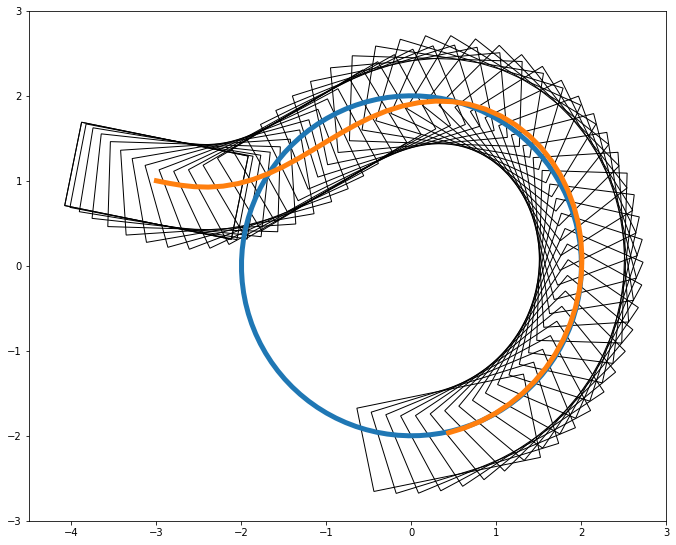

In [14]:
def run_ilqr(x0, N, max_iter=50, regu_init=100):
    # First forward rollout
    u_trj = np.random.randn(N-1, n_u)*0.0001
    x_trj = rollout(x0, u_trj)
    total_cost = cost_trj(x_trj, u_trj)
    regu = regu_init
    max_regu = 10000
    min_regu = 0.01
    
    # Setup traces
    cost_trace = [total_cost]
    expected_cost_redu_trace = []
    redu_ratio_trace = [1]
    redu_trace = []
    regu_trace = [regu]
    
    # Run main loop
    for it in range(max_iter):
        # Backward and forward pass
        k_trj, K_trj, expected_cost_redu = backward_pass(x_trj, u_trj, regu)
        x_trj_new, u_trj_new = forward_pass(x_trj, u_trj, k_trj, K_trj)
        # Evaluate new trajectory
        total_cost = cost_trj(x_trj_new, u_trj_new)
        cost_redu = cost_trace[-1] - total_cost
        redu_ratio = cost_redu / abs(expected_cost_redu)
        # Accept or reject iteration
        if cost_redu > 0:
            # Improvement! Accept new trajectories and lower regularization
            redu_ratio_trace.append(redu_ratio)
            cost_trace.append(total_cost)
            x_trj = x_trj_new
            u_trj = u_trj_new
            regu *= 0.7
        else:
            # Reject new trajectories and increase regularization
            regu *= 2.0
            cost_trace.append(cost_trace[-1])
            redu_ratio_trace.append(0)
        regu = min(max(regu, min_regu), max_regu)
        regu_trace.append(regu)
        redu_trace.append(cost_redu)

        # Early termination if expected improvement is small
        if expected_cost_redu <= 1e-6:
            break
            
    return x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace

# Setup problem and call iLQR
x0 = np.array([-3.0, 1.0, -0.2, 0.0, 0.0])
N = 50
max_iter=50
regu_init=100
x_trj, u_trj, cost_trace, regu_trace, redu_ratio_trace, redu_trace = run_ilqr(x0, N, max_iter, regu_init)


plt.figure(figsize=(9.5,8))
# Plot circle
theta = np.linspace(0, 2*np.pi, 100)
plt.plot(r*np.cos(theta), r*np.sin(theta), linewidth=5)
ax = plt.gca()

# Plot resulting trajecotry of car
plt.plot(x_trj[:,0], x_trj[:,1], linewidth=5)
w = 2.0
h = 1.0

# Plot rectangles
for n in range(x_trj.shape[0]):
    rect = mpl.patches.Rectangle((-w/2,-h/2), w, h, fill=False)
    t = mpl.transforms.Affine2D().rotate_deg_around(0, 0, 
            np.rad2deg(x_trj[n,2])).translate(x_trj[n,0], x_trj[n,1]) + ax.transData
    rect.set_transform(t)
    ax.add_patch(rect)
ax.set_aspect(1)
plt.ylim((-3,3))
plt.xlim((-4.5,3))
plt.tight_layout()

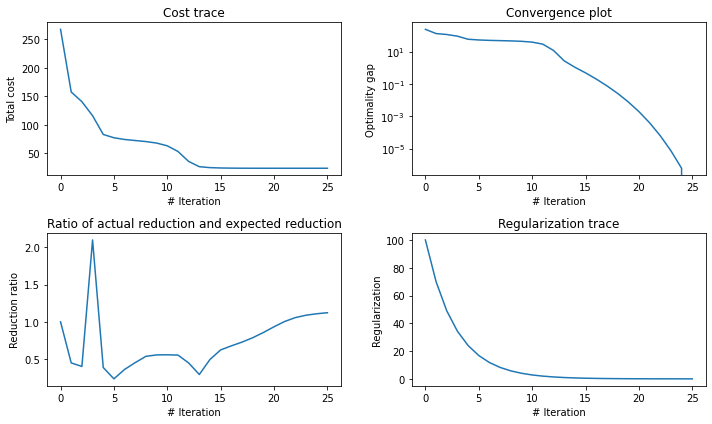

In [15]:
plt.subplots(figsize=(10,6))
# Plot results
plt.subplot(2, 2, 1)
plt.plot(cost_trace)
plt.xlabel('# Iteration')
plt.ylabel('Total cost')
plt.title('Cost trace')

plt.subplot(2, 2, 2)
delta_opt = (np.array(cost_trace) - cost_trace[-1])
plt.plot(delta_opt)
plt.yscale('log')
plt.xlabel('# Iteration')
plt.ylabel('Optimality gap')
plt.title('Convergence plot')

plt.subplot(2, 2, 3)
plt.plot(redu_ratio_trace)
plt.title('Ratio of actual reduction and expected reduction')
plt.ylabel('Reduction ratio')
plt.xlabel('# Iteration')

plt.subplot(2, 2, 4)
plt.plot(regu_trace)
plt.title('Regularization trace')
plt.ylabel('Regularization')
plt.xlabel('# Iteration')
plt.tight_layout()